In [ ]:
library(tidyverse)
library(data.table)

### Load data

In [2]:
# # 1. load trimester h2 estimates
# tri1_h2 <- fread("/u/project/gandalm/danieldu/gcta/data/sliding_fetal/hg19_gene_regressed/results/1Mbase_window/1_to_137_1Mbase_window.csv", data.table = F)
# tri2_h2 <- fread("/u/project/gandalm/danieldu/gcta/data/sliding_fetal/hg19_gene_regressed/results/1Mbase_window/138_to_280_1Mbase_window.csv", data.table = F)

In [3]:
# 2. load sliding batches h2 estimates, filter to shared converged genes
setwd("/u/project/gandalm/danieldu/gcta/data/sliding_fetal/hg19_gene_regressed/results/1Mbase_window/")
batch1 <- fread("1_to_150_1Mbase_window.csv", data.table = F)
batch2 <- fread("26_to_175_1Mbase_window.csv", data.table = F)
batch3 <- fread("51_to_200_1Mbase_window.csv", data.table = F)
batch4 <- fread("76_to_225_1Mbase_window.csv", data.table = F)
batch5 <- fread("101_to_250_1Mbase_window.csv", data.table = F)
batch6 <- fread("126_to_275_1Mbase_window.csv", data.table = F)
batch7 <- fread("151_to_280_1Mbase_window.csv", data.table = F)
shared <- Reduce(intersect, list(batch1$gene, batch2$gene, batch3$gene,
                                 batch4$gene, batch5$gene, batch6$gene,
                                 batch7$gene))
batches <- list(batch1, batch2, batch3, batch4, batch5, batch6, batch7)
for (i in seq_along(batches)) {
  batches[[i]] <- batches[[i]] %>% filter(gene %in% shared)
}

In [4]:
# 3. load metadata, only EUR relevant here
metadata <- read.table("/u/project/gandalm/cindywen/isoform_twas/eqtl_new/metadata_654.tsv", header = T)
metadata <- metadata %>% filter(ancestry == "eur") %>% arrange(Age)
eqtl_samples <- read.table("/u/project/gandalm/cindywen/isoform_twas/eqtl_new/data/90hcp_cov_629.txt", header = T, check.names = F)
metadata <- metadata %>% filter(Subject %in% colnames(eqtl_samples))

In [5]:
# 4. make a df with median and sd of cish2 of all genes per batch
df <- data.frame("mean_age" = NA,
                 "se_age" = NA)
for(i in c(1:7)) {
    start_id <- (i-1)*25+1
    end_id <- start_id + 149
    if(i == 7) {
        end_id <- 280
    }
    df[i,'mean_age'] <- mean(metadata[start_id:end_id,'pcw'])
    df[i,'se_age'] <- sd(metadata[start_id:end_id,'pcw'])/sqrt(150)
}
df$cis_h2 <- df$se <- NA
df[1,"cis_h2"] <- median(batch1$cish2)
df[2,"cis_h2"] <- median(batch2$cish2)
df[3,"cis_h2"] <- median(batch3$cish2)
df[4,"cis_h2"] <- median(batch4$cish2)
df[5,"cis_h2"] <- median(batch5$cish2)
df[6,"cis_h2"] <- median(batch6$cish2)
df[7,"cis_h2"] <- median(batch7$cish2)

df[1,"se"] <- sd(batch1$cish2)/sqrt(31510)
df[2,"se"] <- sd(batch2$cish2)/sqrt(31510)
df[3,"se"] <- sd(batch3$cish2)/sqrt(31510)
df[4,"se"] <- sd(batch4$cish2)/sqrt(31510)
df[5,"se"] <- sd(batch5$cish2)/sqrt(31510)
df[6,"se"] <- sd(batch6$cish2)/sqrt(31510)
df[7,"se"] <- sd(batch7$cish2)/sqrt(31510)

In [6]:
df

,mean_age,se_age,se,cis_h2
,<dbl>,<dbl>,<dbl>,<dbl>
1,10.44047,0.1974379,0.0006523509,0.016946629
2,11.66120,0.1901191,0.0006097135,0.013631718
3,12.94300,0.1695632,0.0005747043,0.011605890
4,14.15687,0.1491077,0.0005433453,0.009920510
5,15.18093,0.1491849,0.0005221255,0.007021143
6,16.29173,0.1649319,0.0005101907,0.004617791
7,17.30692,0.2642946,0.0005379719,0.003828210


In [7]:
# 5. load gene annotation
info <- fread("/u/project/gandalm/cindywen/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table = F)

### cibersortx results: combat-seq gene counts, all bulk samples, top 50 metamarkers

In [26]:
res <- fread("/u/project/gandalm/cindywen/isoform_twas/eqtl_new/CIBERSORTx_Job20_Results.csv", data.table = F)
head(res)

,Mixture,Dividing_Progenitor,GABAergic,Glutamatergic,Intermediate_Progenitor,Neural_Progenitor,Non-neuronal,other,P-value,Correlation,RMSE
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1474,0.44220531,0.02380264,0.2313835,0,0.3026086,0.000000000,0.000000000,0,0.5757229,0.8254365
2,1496,0.05411758,0.08398526,0.5770336,0,0.2785508,0.000000000,0.006312754,0,0.4568592,0.9224043
3,1500,0.36542046,0.03434512,0.3503865,0,0.2462399,0.000000000,0.003608053,0,0.5799266,0.8165581
4,1502,0.14793978,0.12061129,0.4716193,0,0.2452689,0.000000000,0.014560671,0,0.4530543,0.9137569
5,1507,0.17027873,0.01105628,0.4649183,0,0.2106022,0.001486007,0.141658479,0,0.4303234,0.9282461
6,1511,0.45723498,0.00000000,0.1873212,0,0.3483692,0.000000000,0.007074585,0,0.6981223,0.7161401


**1. for each cell type, across 7 batches, calculate the Pearson correlation between `mean cell proportion`, and `median cish2`**

In [27]:
res <- res %>% inner_join(metadata, by = c("Mixture" = "Subject"))
res <- res %>% arrange(Age)
Dividing_Progenitor <- GABAergic <- Glutamatergic <- Intermediate_Progenitor <- Neural_Progenitor <- Non_neuronal <- other <- data.frame("mean_pr" = NA, "se_pr" = NA)
for (i in 1:7) {
        start_id <- (i-1)*25+1
        end_id <- start_id + 149
        if(i == 7) {
            end_id <- 280
        }
    Dividing_Progenitor[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Dividing_Progenitor'])
    Dividing_Progenitor[i,'se_pr'] <- sd(res[(start_id):(end_id),'Dividing_Progenitor'])/sqrt(150)
    GABAergic[i,'mean_pr'] <- mean(res[(start_id):(end_id),'GABAergic'])
    GABAergic[i,'se_pr'] <- sd(res[(start_id):(end_id),'GABAergic'])/sqrt(150)
    Glutamatergic[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Glutamatergic'])
    Glutamatergic[i,'se_pr'] <- sd(res[(start_id):(end_id),'Glutamatergic'])/sqrt(150)
    Intermediate_Progenitor[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Intermediate_Progenitor'])
    Intermediate_Progenitor[i,'se_pr'] <- sd(res[(start_id):(end_id),'Intermediate_Progenitor'])/sqrt(150)
    Neural_Progenitor[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Neural_Progenitor'])
    Neural_Progenitor[i,'se_pr'] <- sd(res[(start_id):(end_id),'Neural_Progenitor'])/sqrt(150)
    Non_neuronal[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Non-neuronal'])
    Non_neuronal[i,'se_pr'] <- sd(res[(start_id):(end_id),'Non-neuronal'])/sqrt(150)
    other[i,'mean_pr'] <- mean(res[(start_id):(end_id),'other'])
    other[i,'se_pr'] <- sd(res[(start_id):(end_id),'other'])/sqrt(150)   
}
combined_dataframe <- df

for (i in 2:7) {
  combined_dataframe <- rbind(combined_dataframe, df)
}
# dim(combined_dataframe)

all_types <- rbind(Dividing_Progenitor, GABAergic, Glutamatergic, Intermediate_Progenitor, Neural_Progenitor, Non_neuronal, other)
df1 <- cbind(combined_dataframe, all_types)
df1$type <- c(rep("Dividing_Progenitor", 7), rep("GABAergic", 7), 
              rep("Glutamatergic", 7), rep("Intermediate_Progenitor", 7), 
              rep("Neural_Progenitor", 7), rep("Non_neuronal", 7), rep("other", 7))

cor.test.df <- data.frame("pvalue" = NA)
types <- c("Dividing_Progenitor", "GABAergic", "Glutamatergic", "Intermediate_Progenitor", "Neural_Progenitor", "Non_neuronal", "other")
for (i in c(1:7)) {
    corr.res <- cor.test(df1[df1$type == types[i], 'cis_h2'], df1[df1$type == types[i], 'mean_pr'], method = 'pearson')
    cor.test.df[i,1] <- corr.res$p.value
    cor.test.df[i,'cell_type'] <- types[i]
    cor.test.df[i,'cor.est'] <- corr.res$estimate
}
cor.test.df$p.FDR <- p.adjust(cor.test.df$pvalue, method = "fdr")
cor.test.df <- cor.test.df %>% arrange(p.FDR)
cor.test.df <- cor.test.df %>% select(cell_type, cor.est, pvalue, p.FDR)
cor.test.df

cell_type,cor.est,pvalue,p.FDR
<chr>,<dbl>,<dbl>,<dbl>
Dividing_Progenitor,0.9558338,0.0007688205,0.005381744
Glutamatergic,-0.9406986,0.0015928604,0.005575011
Neural_Progenitor,0.7527516,0.0508391728,0.118624736
other,0.6908297,0.0856937932,0.149964138
GABAergic,-0.3578053,0.4306953064,0.602973429
Intermediate_Progenitor,-0.1486419,0.7504360216,0.750436022
Non_neuronal,0.1772552,0.7037871295,0.750436022


In [28]:
head(df1)

,mean_age,se_age,se,cis_h2,mean_pr,se_pr,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,10.44047,0.1974379,0.0006523509,0.016946629,0.1476145,0.01335574,Dividing_Progenitor
2,11.66120,0.1901191,0.0006097135,0.013631718,0.1412661,0.01176070,Dividing_Progenitor
3,12.94300,0.1695632,0.0005747043,0.011605890,0.1424105,0.01199460,Dividing_Progenitor
4,14.15687,0.1491077,0.0005433453,0.009920510,0.1323508,0.01130761,Dividing_Progenitor
5,15.18093,0.1491849,0.0005221255,0.007021143,0.1199134,0.01149106,Dividing_Progenitor
6,16.29173,0.1649319,0.0005101907,0.004617791,0.1053246,0.01079709,Dividing_Progenitor


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


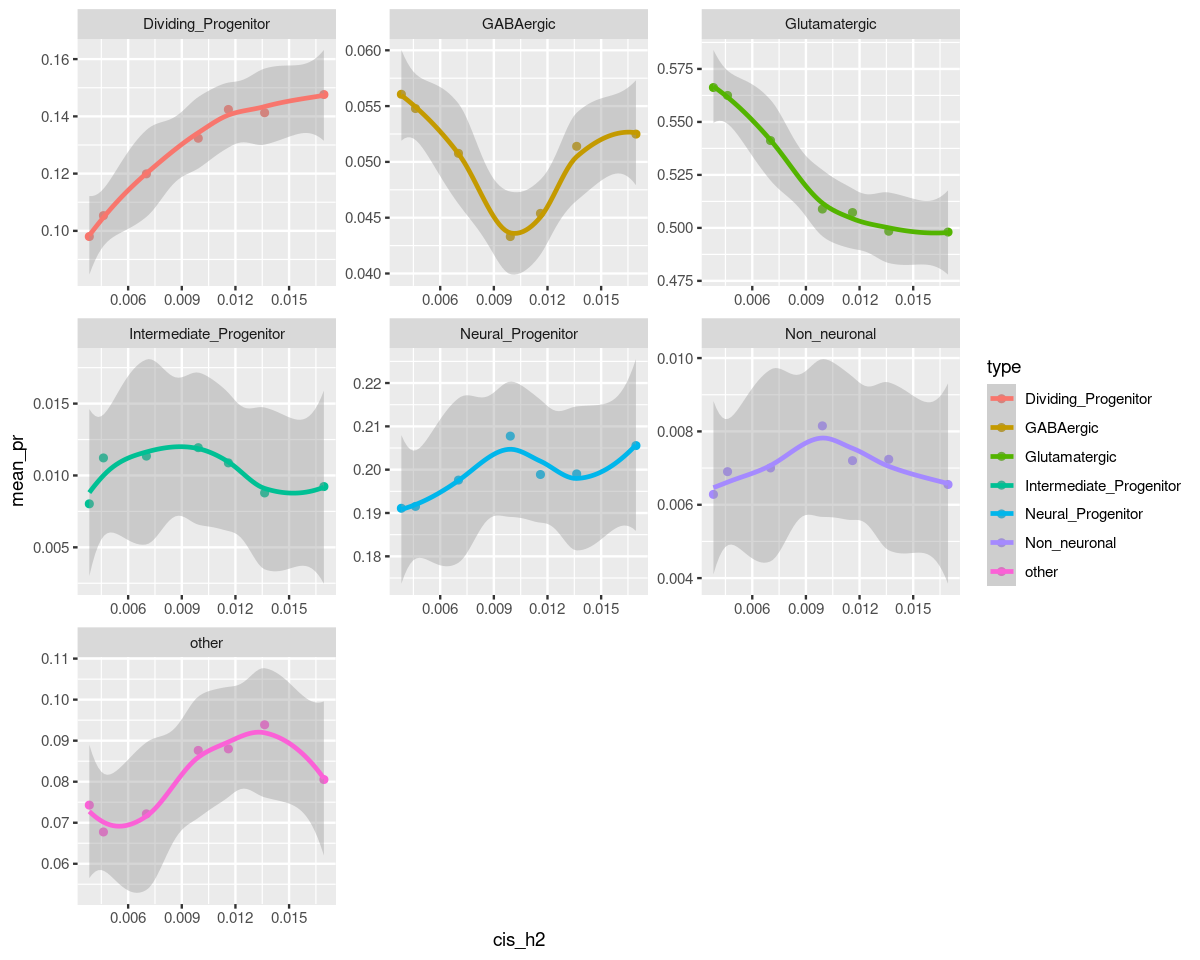

In [14]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(df1, aes(x = cis_h2, y = mean_pr, color = type)) +
    geom_point()+
    geom_smooth() +
    facet_wrap(.~type, scale = "free")

**2. since the sliding batches are overlapping, we now take batch 1 (samples 1-150) and batch 7(samples 151-280)**
- question: what statistics can we do here?

In [31]:
df1$batch <- rep(c(1:7),7)

In [32]:
df1_subet <- df1 %>% filter(batch %in% c(1, 7))
df1_subset

mean_age,se_age,se,cis_h2,mean_pr,se_pr,type,batch
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
10.44047,0.1974379,0.0006523509,0.01694663,0.147614465,0.013355735,Dividing_Progenitor,1
17.30692,0.2642946,0.0005379719,0.00382821,0.098014645,0.010710210,Dividing_Progenitor,7
10.44047,0.1974379,0.0006523509,0.01694663,0.052490442,0.004493341,GABAergic,1
17.30692,0.2642946,0.0005379719,0.00382821,0.056058777,0.005603613,GABAergic,7
10.44047,0.1974379,0.0006523509,0.01694663,0.498032937,0.014058071,Glutamatergic,1
17.30692,0.2642946,0.0005379719,0.00382821,0.566232367,0.014793710,Glutamatergic,7
10.44047,0.1974379,0.0006523509,0.01694663,0.009227761,0.002376855,Intermediate_Progenitor,1
17.30692,0.2642946,0.0005379719,0.00382821,0.008026936,0.002407260,Intermediate_Progenitor,7
10.44047,0.1974379,0.0006523509,0.01694663,0.205559731,0.007893272,Neural_Progenitor,1


### cibersortx results: HCP corrected gene expression, all bulk samples, top 50 metamarkers

**1. we still see correlation between `median_cish2` and `mean_cellprop`**

In [8]:
res <- fread("/u/project/gandalm/cindywen/isoform_twas/eqtl_new/CIBERSORTx_Job21_Results.csv", data.table = F)
res <- res %>% inner_join(metadata, by = c("Mixture" = "Subject"))
res <- res %>% arrange(Age)

In [9]:
Dividing_Progenitor <- GABAergic <- Glutamatergic <- Intermediate_Progenitor <- Neural_Progenitor <- Non_neuronal <- other <- data.frame("mean_pr" = NA, "se_pr" = NA)
for (i in 1:7) {
        start_id <- (i-1)*25+1
        end_id <- start_id + 149
        if(i == 7) {
            end_id <- 280
        }
    Dividing_Progenitor[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Dividing_Progenitor'])
    Dividing_Progenitor[i,'se_pr'] <- sd(res[(start_id):(end_id),'Dividing_Progenitor'])/sqrt(150)
    GABAergic[i,'mean_pr'] <- mean(res[(start_id):(end_id),'GABAergic'])
    GABAergic[i,'se_pr'] <- sd(res[(start_id):(end_id),'GABAergic'])/sqrt(150)
    Glutamatergic[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Glutamatergic'])
    Glutamatergic[i,'se_pr'] <- sd(res[(start_id):(end_id),'Glutamatergic'])/sqrt(150)
    Intermediate_Progenitor[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Intermediate_Progenitor'])
    Intermediate_Progenitor[i,'se_pr'] <- sd(res[(start_id):(end_id),'Intermediate_Progenitor'])/sqrt(150)
    Neural_Progenitor[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Neural_Progenitor'])
    Neural_Progenitor[i,'se_pr'] <- sd(res[(start_id):(end_id),'Neural_Progenitor'])/sqrt(150)
    Non_neuronal[i,'mean_pr'] <- mean(res[(start_id):(end_id),'Non-neuronal'])
    Non_neuronal[i,'se_pr'] <- sd(res[(start_id):(end_id),'Non-neuronal'])/sqrt(150)
    other[i,'mean_pr'] <- mean(res[(start_id):(end_id),'other'])
    other[i,'se_pr'] <- sd(res[(start_id):(end_id),'other'])/sqrt(150)   
}
combined_dataframe <- df

for (i in 2:7) {
  combined_dataframe <- rbind(combined_dataframe, df)
}
# dim(combined_dataframe)

all_types <- rbind(Dividing_Progenitor, GABAergic, Glutamatergic, Intermediate_Progenitor, Neural_Progenitor, Non_neuronal, other)
df1 <- cbind(combined_dataframe, all_types)
df1$type <- c(rep("Dividing_Progenitor", 7), rep("GABAergic", 7), 
              rep("Glutamatergic", 7), rep("Intermediate_Progenitor", 7), 
              rep("Neural_Progenitor", 7), rep("Non_neuronal", 7), rep("other", 7))

cor.test.df <- data.frame("pvalue" = NA)
types <- c("Dividing_Progenitor", "GABAergic", "Glutamatergic", "Intermediate_Progenitor", "Neural_Progenitor", "Non_neuronal", "other")
for (i in c(1:7)) {
    corr.res <- cor.test(df1[df1$type == types[i], 'cis_h2'], df1[df1$type == types[i], 'mean_pr'], method = 'pearson')
    cor.test.df[i,1] <- corr.res$p.value
    cor.test.df[i,'cell_type'] <- types[i]
    cor.test.df[i,'cor.est'] <- corr.res$estimate
}
cor.test.df$p.FDR <- p.adjust(cor.test.df$pvalue, method = "fdr")
cor.test.df <- cor.test.df %>% arrange(p.FDR)
cor.test.df <- cor.test.df %>% select(cell_type, cor.est, pvalue, p.FDR)
cor.test.df

cell_type,cor.est,pvalue,p.FDR
<chr>,<dbl>,<dbl>,<dbl>
GABAergic,0.8902013,0.007226218,0.02529176
Glutamatergic,-0.8997585,0.005785531,0.02529176
Dividing_Progenitor,0.6698244,0.099732280,0.22888287
Non_neuronal,-0.6282675,0.130790214,0.22888287
Intermediate_Progenitor,0.5334174,0.217571123,0.30459957
other,0.4194235,0.348904682,0.40705546
Neural_Progenitor,-0.2792767,0.544156183,0.54415618


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


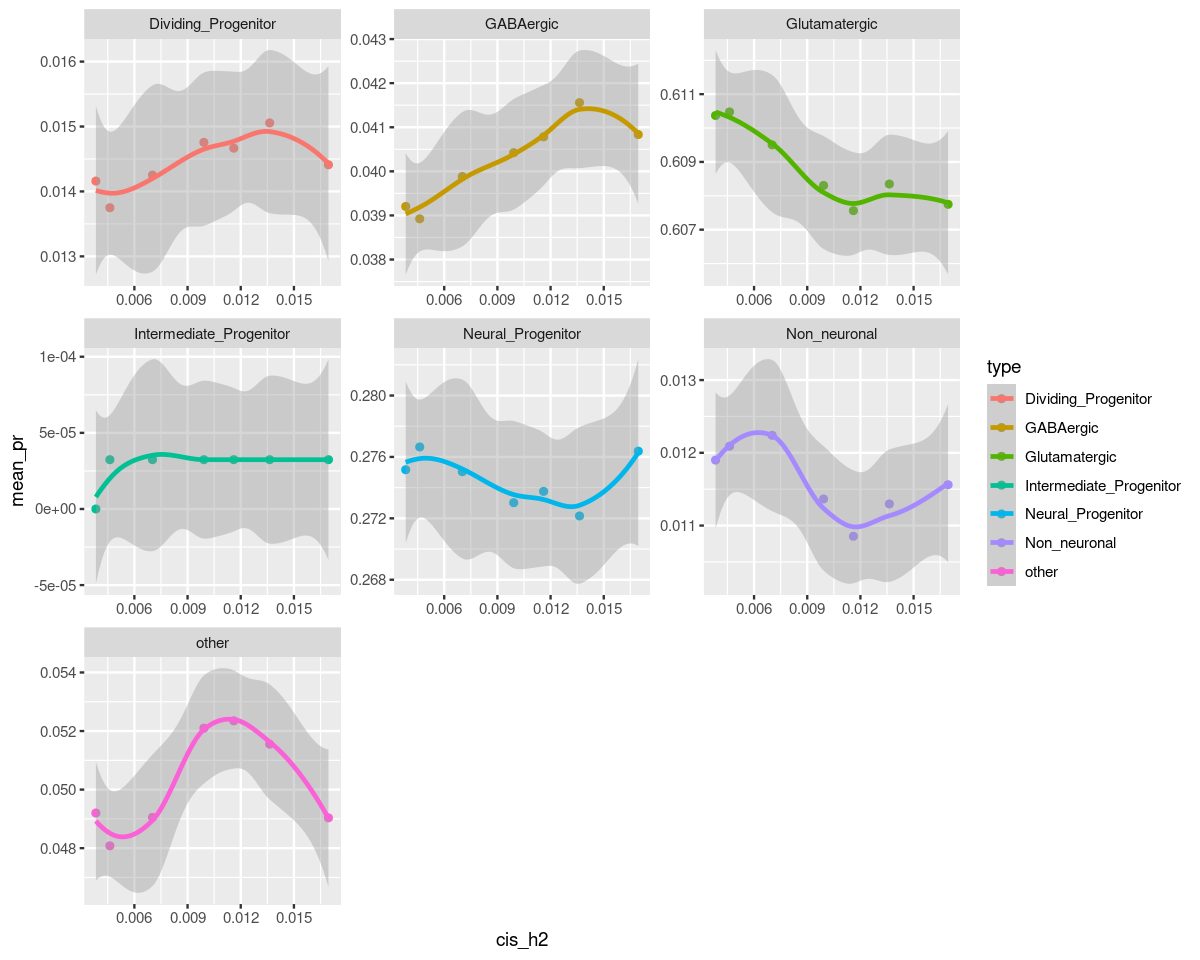

In [46]:
ggplot(df1, aes(x = cis_h2, y = mean_pr, color = type)) +
    geom_point()+
    geom_smooth() +
    facet_wrap(.~type, scale = "free")

In [47]:
head(df1)

,mean_age,se_age,se,cis_h2,mean_pr,se_pr,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,10.44047,0.1974379,0.0006523509,0.016946629,0.01441068,0.001634052,Dividing_Progenitor
2,11.66120,0.1901191,0.0006097135,0.013631718,0.01505580,0.001579946,Dividing_Progenitor
3,12.94300,0.1695632,0.0005747043,0.011605890,0.01466642,0.001607290,Dividing_Progenitor
4,14.15687,0.1491077,0.0005433453,0.009920510,0.01475605,0.001586735,Dividing_Progenitor
5,15.18093,0.1491849,0.0005221255,0.007021143,0.01425191,0.001546407,Dividing_Progenitor
6,16.29173,0.1649319,0.0005101907,0.004617791,0.01374867,0.001420974,Dividing_Progenitor


In [14]:
head(res)

,Mixture,Dividing_Progenitor,GABAergic,Glutamatergic,Intermediate_Progenitor,Neural_Progenitor,Non-neuronal,other,P-value,Correlation,RMSE,Age,Sex,inferSex,trimester,ancestry,study,pcw
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
1,11903,0.069763596,0.03789465,0.5602696,0,0.2162670,0.0083573290,0.10744779,0,0.5689848,0.8276217,-0.6904110,F,F,1,eur,hdbr,4
2,11397,0.076452529,0.02740346,0.6047291,0,0.2645586,0.0040636023,0.02279269,0,0.6145014,0.7927675,-0.6712329,F,F,1,eur,hdbr,5
3,11931,0.000000000,0.04601153,0.6114459,0,0.3106003,0.0200714147,0.01187089,0,0.5928330,0.8155942,-0.6520548,NA,F,1,eur,hdbr,6
4,1038,0.000000000,0.09719701,0.5715200,0,0.2354686,0.0232643180,0.07255005,0,0.6012223,0.8021590,-0.6328767,M,M,1,eur,hdbr,7
5,11122,0.000000000,0.06778536,0.5979785,0,0.2646062,0.0123091217,0.05732080,0,0.6094737,0.7975460,-0.6328767,F,F,1,eur,hdbr,7
6,11363,0.002633553,0.02134105,0.6340926,0,0.2988205,0.0001671336,0.04294519,0,0.6188843,0.7931728,-0.6328767,F,F,1,eur,hdbr,7


In [15]:
dim(res)

[1] 280  18

**are cellprop different between youngest and oldest batches?**

In [18]:
t.test(res[1:150,'Dividing_Progenitor'], res[151:280,'Dividing_Progenitor'])


	Welch Two Sample t-test

data:  res[1:150, "Dividing_Progenitor"] and res[151:280, "Dividing_Progenitor"]
t = 0.11118, df = 277.82, p-value = 0.9116
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.004195104  0.004697347
sample estimates:
 mean of x  mean of y 
0.01441068 0.01415956 


In [17]:
t.test(res[1:150,'GABAergic'], res[151:280,'GABAergic'])
t.test(res[1:150,'Glutamatergic'], res[151:280,'Glutamatergic'])
t.test(res[1:150,'Intermediate_Progenitor'], res[151:280,'Intermediate_Progenitor'])
t.test(res[1:150,'Neural_Progenitor'], res[151:280,'Neural_Progenitor'])
t.test(res[1:150,'Non-neuronal'], res[151:280,'Non-neuronal'])
t.test(res[1:150,'other'], res[151:280,'other'])


	Welch Two Sample t-test

data:  res[1:150, "GABAergic"] and res[151:280, "GABAergic"]
t = 0.62083, df = 268.35, p-value = 0.5352
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.003541348  0.006803308
sample estimates:
 mean of x  mean of y 
0.04083480 0.03920382 



	Welch Two Sample t-test

data:  res[1:150, "Glutamatergic"] and res[151:280, "Glutamatergic"]
t = -0.49226, df = 248.18, p-value = 0.623
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.013115424  0.007870382
sample estimates:
mean of x mean of y 
0.6077482 0.6103707 



	Welch Two Sample t-test

data:  res[1:150, "Intermediate_Progenitor"] and res[151:280, "Intermediate_Progenitor"]
t = 1, df = 149, p-value = 0.3189
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.161094e-05  9.638657e-05
sample estimates:
   mean of x    mean of y 
3.238782e-05 0.000000e+00 



	Welch Two Sample t-test

data:  res[1:150, "Neural_Progenitor"] and res[151:280, "Neural_Progenitor"]
t = 0.18887, df = 258.57, p-value = 0.8503
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01141454  0.01383640
sample estimates:
mean of x mean of y 
0.2763767 0.2751658 



	Welch Two Sample t-test

data:  res[1:150, "Non-neuronal"] and res[151:280, "Non-neuronal"]
t = -0.27342, df = 257.18, p-value = 0.7847
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002773676  0.002097343
sample estimates:
 mean of x  mean of y 
0.01156143 0.01189960 



	Welch Two Sample t-test

data:  res[1:150, "other"] and res[151:280, "other"]
t = -0.035613, df = 266.79, p-value = 0.9716
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.009271935  0.008942475
sample estimates:
 mean of x  mean of y 
0.04903579 0.04920052 


**the distribution of correlation between a constant_group and a changing_group**

In [20]:
constant_group <- c(5, 5, 5, 5, 5.2)
changing_group <- c(2, 4, 6, 8, 10)

correlation <- cor(constant_group, changing_group)
print(correlation)

[1] 0.7071068


In [21]:
cor.test(constant_group, changing_group, method = 'pearson')


	Pearson's product-moment correlation

data:  constant_group and changing_group
t = 1.7321, df = 3, p-value = 0.1817
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4656725  0.9787645
sample estimates:
      cor 
0.7071068 


In [31]:
head(correlation_values)

[1] -0.22891829  0.00186107  0.10788599  0.07591931  0.16451904  0.01263143

In [35]:
num_simulations <- 1000
group_length <- 7

correlation_values <- numeric(num_simulations)

for (i in 1:num_simulations) {
    constant_group <- rep(5, group_length) + rnorm(group_length, mean = 0, sd = 0.1)
    changing_group <- rnorm(group_length, mean = 5, sd = 1)  
    correlation_values[i] <- cor(constant_group, changing_group)
}

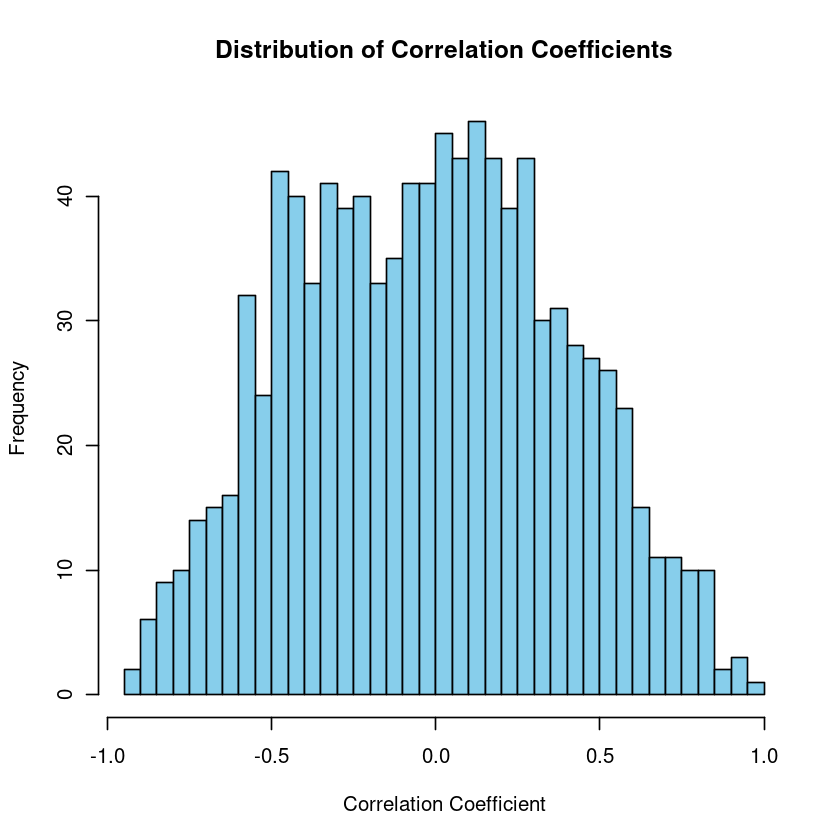

In [36]:
hist(correlation_values, breaks = 30, main = "Distribution of Correlation Coefficients",
     xlab = "Correlation Coefficient", col = "skyblue")